# Paper Appendix: Results are insensitive to method chosen

Here we compare the resulting small scale contribution from two different 'smoothing' methods:
- Coarsening: This is a Reynolds Operator, hence $Q^{**} = Q^*$
- Filtering: -> Refer to methods section and justification of using $Q^{**}$

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [1]:
from distributed import Client
client = Client()
client

# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()
# print('setting up new cluster')

# options = gateway.cluster_options()
# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# cluster.scale(100)
# client

2023-02-24 17:41:35,390 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-9tgs5s2_', purging
2023-02-24 17:41:35,391 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-87jxay61', purging
2023-02-24 17:41:35,391 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5jmvsdtb', purging
2023-02-24 17:41:35,392 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-hqj8ucpu', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45035,Workers: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:37771,Total threads: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/46259/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:44499,


In [2]:
def coarsen(ds):
    return weighted_coarsen(ds,{'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 'area_t')

def global_mean(ds):
    return ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean'])

In [3]:
import gcsfs
import xarray as xr
import numpy as np
from scale_aware_air_sea.utils import filter_inputs_dataset, to_zarr_split, open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params
import matplotlib.pyplot as plt

fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v0.7.0', test=False) 
mapper_filter_flux_decomposition_monthly = fs.get_mapper(params['paths']['CM26']['filter_decomposition_monthly'])
mapper_coarse_flux_decomposition_monthly = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_monthly'])

mapper_filter_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['filter_decomposition_mean'])
mapper_coarse_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_mean'])

In [4]:
ds_filter_monthly = open_zarr(mapper_filter_flux_decomposition_monthly)
ds_coarse_monthly = open_zarr(mapper_coarse_flux_decomposition_monthly, chunks={'time':3000})

ds_filter_mean = open_zarr(mapper_filter_flux_decomposition_mean)
ds_coarse_mean = open_zarr(mapper_coarse_flux_decomposition_mean)

## Notes

- Seems like the daily filter dataset is incomplete (time steps at the end missing).

## Compare global average timeseries

In [5]:
ds_filter_global_mean = global_mean(ds_filter_monthly).sel(term='Q_star_star').load()
ds_coarse_global_mean = global_mean(ds_coarse_monthly).sel(term='Q_star').load()

In [10]:
%matplotlib inline
from xarrayutils.plotting import shaded_line_plot

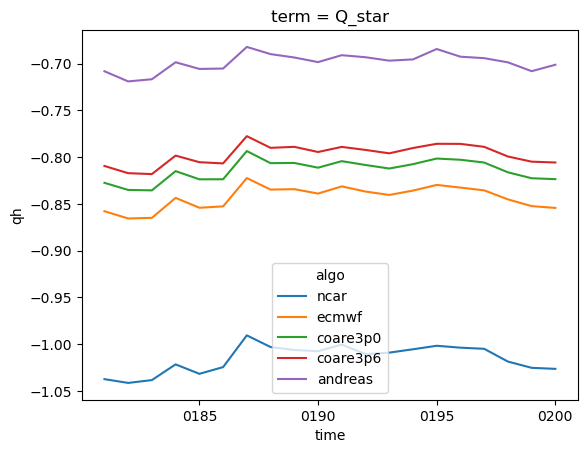

In [17]:
ds_coarse_global_mean.qh.plot(hue='algo')

ValueError: 'algo' not found in array dimensions ()

<Figure size 1000x800 with 0 Axes>

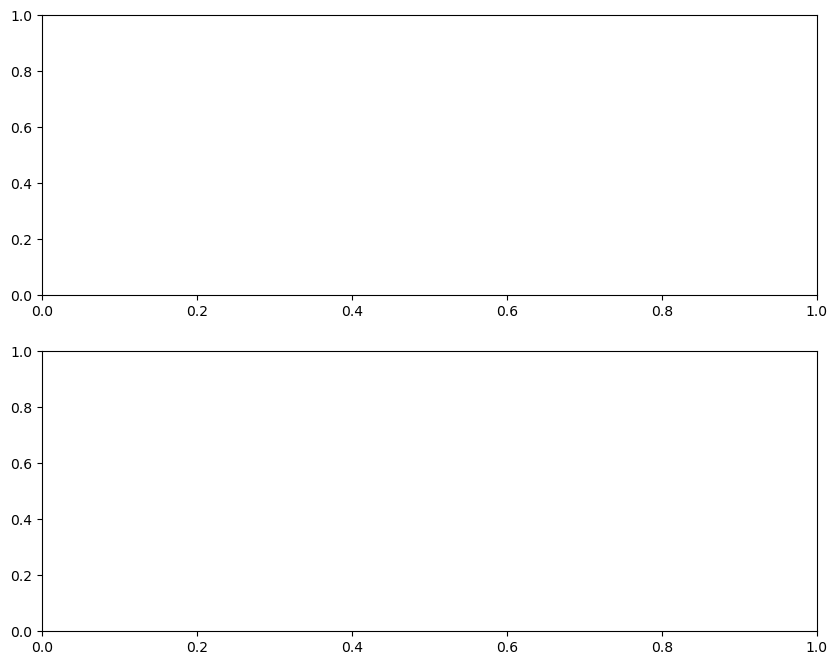

In [15]:
plt.figure(figsize=[10, 8])
fig, axarr = plt.subplots(nrows=2,figsize=[10, 8]) 
for var, ax in zip(['ql', 'qh'], axarr.flat):
    shaded_line_plot(
        ds_coarse_global_mean[var].mean(),
        'algo',
        spread_style='quantile',
        spreads=[1.0],
        alphas=[0.3],
        line_kwargs={'color':'C0', 'label':'coarsened ($Q^{*}$)'},
        ax = ax,
    )# show the full range
    shaded_line_plot(
        ds_filter_global_mean[var].mean(),
        'algo',
        spread_style='quantile',
        spreads=[1.0],
        alphas=[0.3],
        line_kwargs={'color':'C1', 'label':'filtered ($Q^{**}$)'},
        ax = ax,
    )# show the full range
    ax.legend()
    ax.set_title(f'Global average {var} with algo spread')
plt.show()

## Compare time average maps (for small test)

Text(0.5, 1.0, 'Difference')

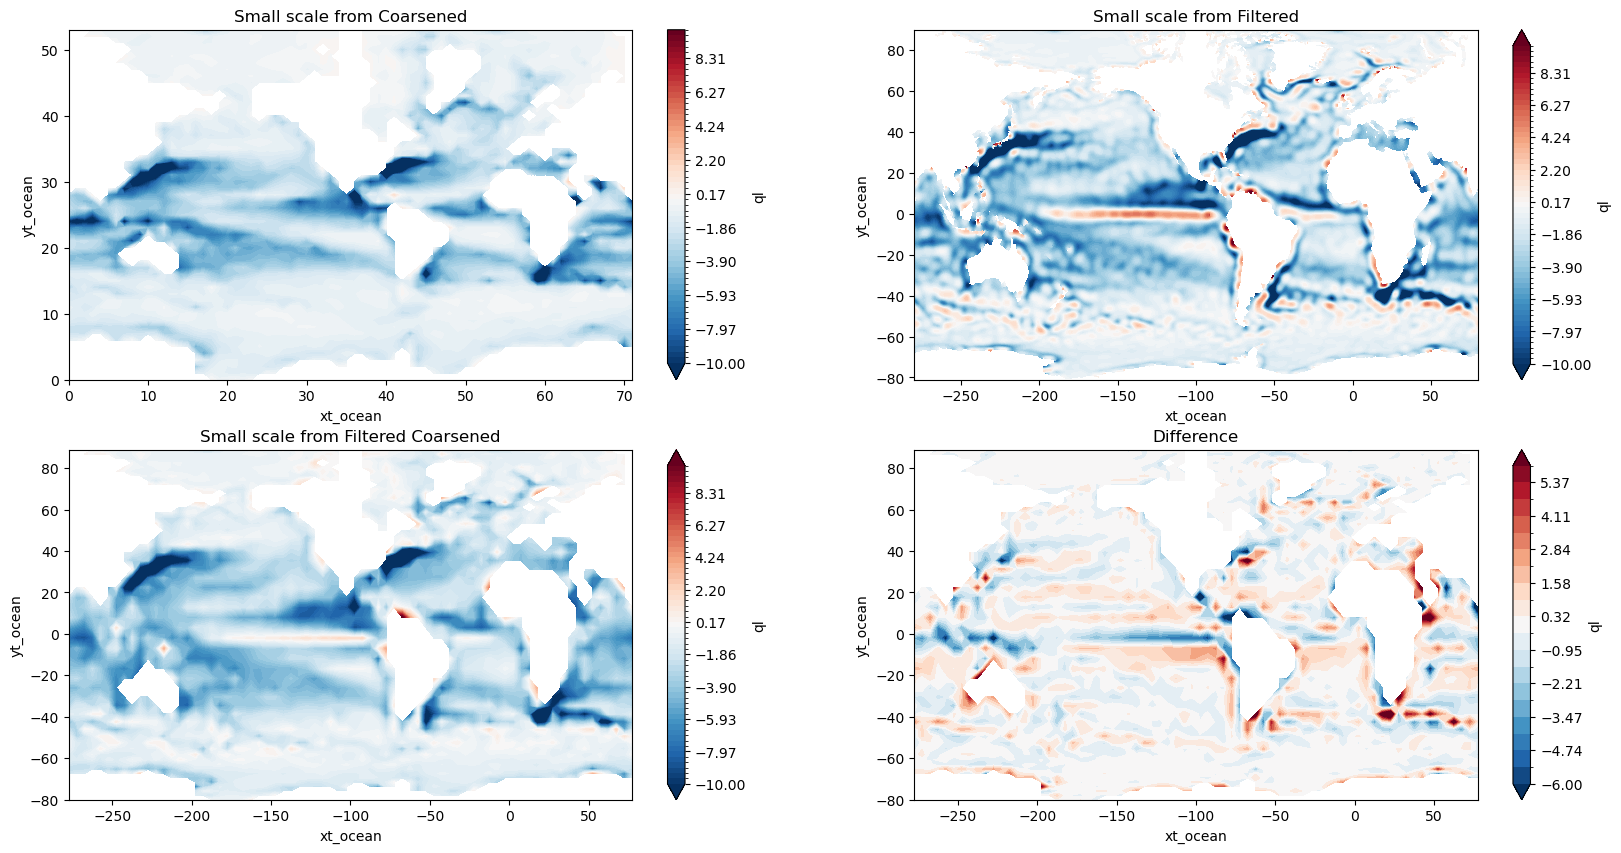

In [17]:
levels=np.linspace(-10, 10, 60)
diff_levels=np.linspace(-6, 6, 20)

for var in ['ql', 'qh']:
    for algo in ds_filter_mean.algo:

        ds_filter_map = ds_filter_mean.sel(algo=algo, term='Q_star_star').load()
        ds_coarse_map = ds_coarse_mean.sel(algo=algo, term='Q_star').load()


        map_coarse = ds_coarse_map[var]
        map_filter = ds_filter_map[var]
        map_filter_coarsened = coarsen(ds_filter_map)[var]
        map_diff = map_coarse - map_filter_coarsened

        plt.figure(figsize=[20, 10])
        plt.subplot(2,2,1)
        map_coarse.plot.contourf(levels=levels)
        plt.title(f'Small scale from Coarsened {var} {algo}')

        plt.subplot(2,2,2)
        map_filter.plot.contourf(levels=levels)
        plt.title(f'Small scale from Filtered {var} {algo}')

        plt.subplot(2,2,3)
        map_filter_coarsened.plot.contourf(levels=levels)
        plt.title(f'Small scale from Filtered Coarsened {var} {algo}')

        plt.subplot(2,2,4)
        map_diff.plot.contourf(levels=diff_levels)
        plt.title(f'Difference')

## scatter plot (for full test time)

In [45]:
from xhistogram.xarray import histogram
x = ds_coarse.ql.sel(term='Q_star')
x.name = 'ql_coarse'
# y = coarsen(ds_smooth).ql
y = coarsen(ds_filter).ql.sel(term='Q_star_star')
y.name = 'ql_filter'

In [46]:
# investigate time averages
x = x.coarsen(time=300).mean()
y = y.coarsen(time=300).mean()

In [49]:
bins = np.linspace(-40, 40, 50)
hist = histogram(x, y, bins=[bins, bins], dim=['xt_ocean', 'yt_ocean', 'time']).load()
hist

<xarray.DataArray 'histogram_ql_coarse_ql_filter' (algo: 2, ql_coarse_bin: 99,
                                                   ql_filter_bin: 99)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * algo           (algo) <U5 'ncar' 'ecmwf'
  * ql_coarse_bin  (ql_coarse_bin) float64 -39.6 -38.79 -37.98 ... 38.79 39.6
  * ql_filter_bin  (ql_filter_bin) float64 -39.6 -38.79 -37.98 ... 38.79 39.6

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_2289/3450268573.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


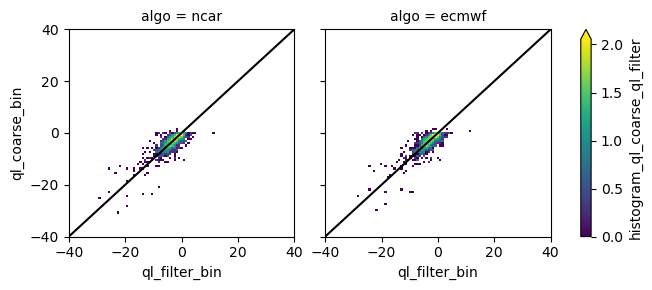

In [50]:
p = np.log10(hist).plot(col='algo', robust=True)
for ax in p.axes.flat:
    ax.plot(bins, bins, color='k')

For no time averaging: The point by point correlation seems fairly low actually, I wonder if this is relevant though...

For 30 day averaging: Seems to improve things a fair bit. 

I guess we need to make a final call, when we have more data.

## Dummy test: Is the filtering linear? YUP it is!

Can I just average in time before filtering?

In [10]:
# test with coarse only
test = (ds_coarse_mean - ds_coarse_daily.mean('time')).load()

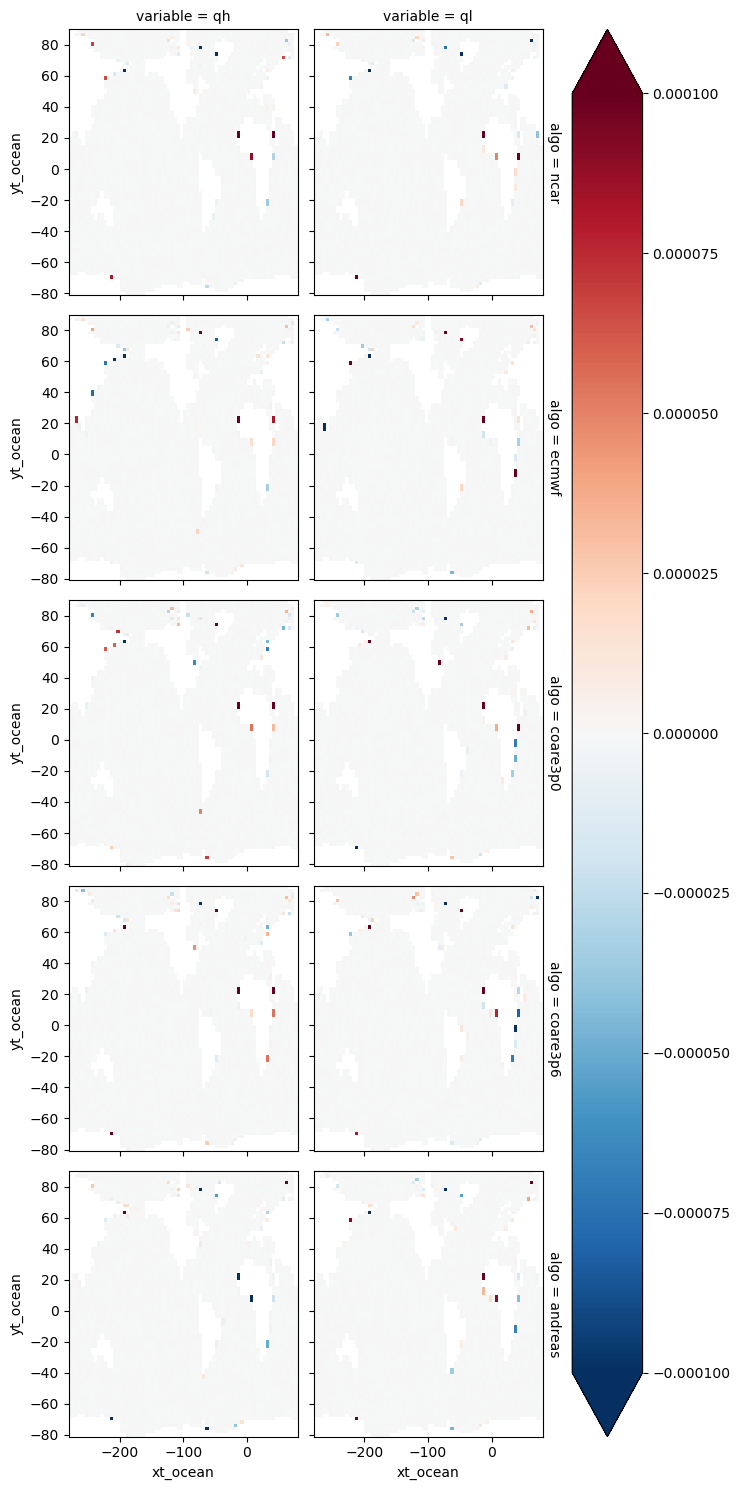

In [14]:
test_rel = test/ds_coarse_mean
test_rel.sel(term='Q_star').to_array().plot(col='variable', row='algo', vmax=0.0001)